# Week 6: 2-Mode Davis Club Network Analysis

## Data 620 Web Analytics

### Kyle Gilde

### 10/5/18

## Data Background

According to [UCINET IV Datasets](http://vlado.fmf.uni-lj.si/pub/networks/data/ucinet/ucidata.htm#davis), "these data were collected by Davis et al in the 1930s. They represent observed attendance at 14 social events by 18 Southern women. The result is a person-by-event matrix: cell (i,j) is 1 if person i attended social event j, and 0 otherwise." 

References:

Breiger R. (1974). The duality of persons and groups. Social Forces, 53, 181-190.
Davis, A et al. (1941). Deep South. Chicago: University of Chicago Press.

## Creating the Graphs

The following code & functions come from the [NetworkX Davis Club page](https://networkx.github.io/documentation/networkx-1.9/examples/algorithms/davis_club.html). 

- the `davis_club_graph` function creates a bipartite graph from the data

- the `project` function creates a unipartite projection of a bipartite graph


In [57]:
import networkx as nx
import string
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

__author__ = """Aric Hagberg (hagberg@lanl.gov)"""
__date__ = "$Date: 2005-05-12 14:33:11 -0600 (Thu, 12 May 2005) $"
__credits__ = """"""
__revision__ = "$Revision: 998 $"

#    Copyright (C) 2004 by
#    Aric Hagberg <hagberg@lanl.gov>
#    Dan Schult <dschult@colgate.edu>
#    Pieter Swart <swart@lanl.gov>
#    All rights reserved.
#    BSD license.

def davis_club_graph(create_using=None, **kwds):
    nwomen = 14
    nclubs = 18
    G = nx.generators.empty_graph(nwomen + nclubs, create_using=create_using, **kwds)
    G.clear()
    G.name = "Davis Southern Club Women"

    women="""\
EVELYN
LAURA
THERESA
BRENDA
CHARLOTTE
FRANCES
ELEANOR
PEARL
RUTH
VERNE
MYRNA
KATHERINE
SYLVIA
NORA
HELEN
DOROTHY
OLIVIA
FLORA"""

    clubs="""\
E1
E2
E3
E4
E5
E6
E7
E8
E9
E10
E11
E12
E13
E14"""

    davisdat="""\
1 1 1 1 1 1 0 1 1 0 0 0 0 0
1 1 1 0 1 1 1 1 0 0 0 0 0 0
0 1 1 1 1 1 1 1 1 0 0 0 0 0
1 0 1 1 1 1 1 1 0 0 0 0 0 0
0 0 1 1 1 0 1 0 0 0 0 0 0 0
0 0 1 0 1 1 0 1 0 0 0 0 0 0
0 0 0 0 1 1 1 1 0 0 0 0 0 0
0 0 0 0 0 1 0 1 1 0 0 0 0 0
0 0 0 0 1 0 1 1 1 0 0 0 0 0
0 0 0 0 0 0 1 1 1 0 0 1 0 0
0 0 0 0 0 0 0 1 1 1 0 1 0 0
0 0 0 0 0 0 0 1 1 1 0 1 1 1
0 0 0 0 0 0 1 1 1 1 0 1 1 1
0 0 0 0 0 1 1 0 1 1 1 1 1 1
0 0 0 0 0 0 1 1 0 1 1 1 1 1
0 0 0 0 0 0 0 1 1 1 0 1 0 0
0 0 0 0 0 0 0 0 1 0 1 0 0 0
0 0 0 0 0 0 0 0 1 0 1 0 0 0"""

    # women names
    w = {}
    n = 0
    for name in women.split('\n'):
        w[n] = name
        n += 1

    # club names
    c = {}
    n = 0
    for name in clubs.split('\n'):
        c[n] = name
        n += 1

    # parse matrix
    row = 0
    for line in davisdat.split('\n'):
        thisrow = list(map(int, line.split(' ')))
        for col in range(0, len(thisrow)):
            if thisrow[col] == 1:
                G.add_edge(w[row], c[col])
        row += 1
    return (G, list(w.values()), list(c.values()))


def project(B, pv, result=False, **kwds):
    """
    Returns a graph that is the unipartite projection of the
    bipartite graph B onto the set of nodes given in list pv.

    The nodes retain their names and are connected if they share a
    common node in the vertex set of {B not pv}.

    No attempt is made to verify that the input graph B is bipartite.
    """
    if result:
        G = result
    else:
        G = nx.Graph(**kwds)
    for v in pv:
        G.add_node(v)
        for cv in B.neighbors(v):
            G.add_edges_from([(v, u) for u in B.neighbors(cv)])
    return G

## Analysis

Let's load and create the bipartite graph and the two unipartite graphs for the women and clubs.

In [102]:
# return graph and women and clubs lists
(G, women, clubs) = davis_club_graph()

# project bipartite graph onto women nodes
W = project(G, women)
# project bipartite graph onto club nodes
C = project(G, clubs)

### Unipartite Club/Event Graph

First, let's examine the club graph. This graph can be created by multiplying the transposition of bipartite adjacency matrix by itself.

From the graph below, we notice that there are four nodes, E6 - E9, that are centrally located, and they appear to connect the two halves of the network. Let's see if these nodes are boundary spanners and have high betweenness centrality.

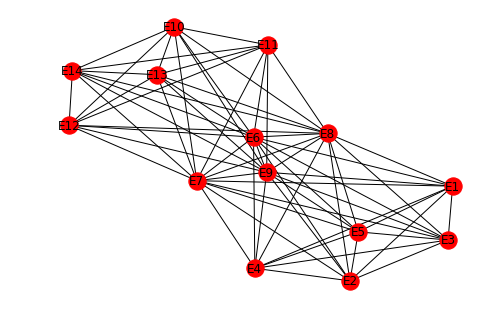

In [75]:
nx.draw(C, with_labels=True)

Betweenness is calculated by computing Dijkstra's shortest paths, counting the number of paths that the node is on and normalizing that number.

The table below confirms that these four nodes are in fact the only nodes that have any betweenness at all. They do serve as bridges between the other events. The other nodes would not be connected if it were not for the existence of these boundary spanners.

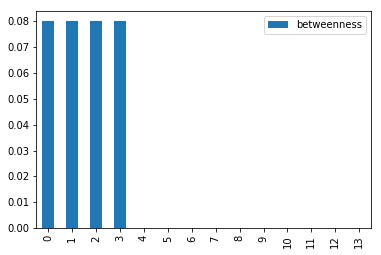

In [142]:
def dict_to_sorted_df(a_dict, col1, col2):
    sorted_list = sorted(a_dict.items(), key=lambda kv: kv[1], reverse=True)
    df = pd.DataFrame(sorted_list, columns=[col1, col2])
    return df

betweenness_df = dict_to_sorted_df(nx.betweenness_centrality(C), 'node', 'betweenness')    
betweenness_df.plot.bar()


### Unipartite Women Graph


Next, let's examine the graph of the women. This graph can be created by multiplying the bipartite adjacency matrix by its transposition.

Unlike the bridges that were in the club graph, there appears to a high degree of connections between the nodes. Let's find out what the clustering coefficient is for the network and how large the cliques are.

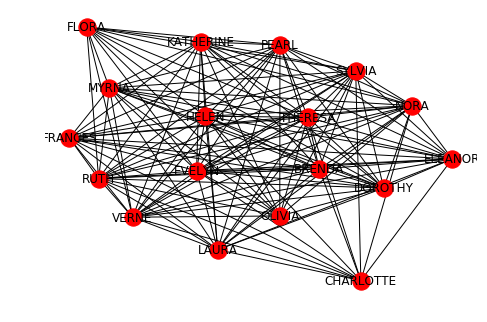

In [49]:
nx.draw(W, with_labels=True)

With a coefficient near 1, there is a high degree of clustering in the network. .94 represents the proportion of "mutual friendships," i.e. the node's neighbors are also connected.

In [91]:
nx.average_clustering(W)

0.9366868969810146

A clique is a maximal complete subgraph, which means that every node is connected to every other node.

The women's graph contains 3 cliques, and they are fairly large.

In [105]:
clique_list = list(nx.find_cliques(W))
[len(clique) for clique in clique_list]

[12, 15, 13]

### Bipartite Graph

Finally, let's examine the relationships between to the two modes of the bipartite graph. In the graph below, we see varying degrees of women who attend events and varing degrees of event attendance.  

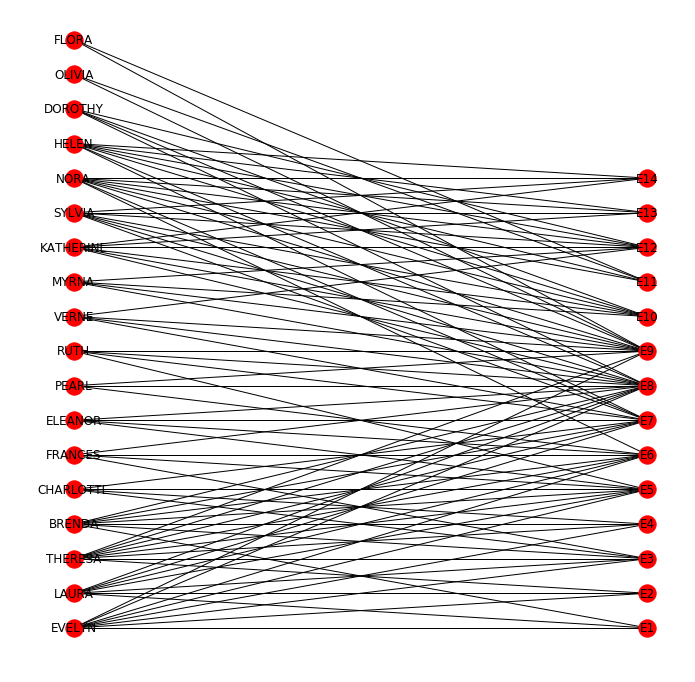

In [123]:
from networkx.algorithms import bipartite as bp

plt.figure(figsize=(9, 9))
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(women) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(clubs) ) # put nodes from Y at x=2
nx.draw(G, pos=pos, with_labels=True)
plt.show()
#source: https://stackoverflow.com/questions/27084004/bipartite-graph-in-networkx

At .37, the density of the edges between the modes is not high. The graph is far from having the maximal amount of edges.

In [127]:
bp.density(G, women)
# source: https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html

0.36904761904761907

Lastly, we see that the clubs have a greater average betweenness than the women.

In [177]:
bp_betweenness_df = dict_to_sorted_df(bp.betweenness_centrality(G, women), 'node', 'degree')    

print(bp_betweenness_df[bp_betweenness_df.node.isin(women)].mean())
print(bp_betweenness_df[bp_betweenness_df.node.isin(clubs)].mean())

degree    0.03608
dtype: float64
degree    0.055468
dtype: float64
